# Lab 9: Keyword Recognition

## Part 1: Making a Digit Recognizer

In this section we will design a simple spoken digit recognizer, based on Dynamic Time Warping (DTW). In order to make such a system we need to first collect some data, and then design a DTW routine that can compare new inputs with templates for each digit.

To start with make a set of data that will be used here. Make a dozen or so recordings of yourself speaking each of the ten digits (0 to 9). We will use one recording from each digit as the template, and the rest at testing data. In order to not spend too much time collecting the data, record all these utterances in a single (long) sound file. Use your voice activity detector to split that file into the individual spoken digits.

In order to design a digit recognizer we will take a spoken input of a digit and compare it to each digit’s template. By finding which template is the most similar we can classify the input as belonging to that template’s digit. In order to measure the distance between the two sequences we have to use DTW on an appropriate feature space.

Decide which feature to use to represent your speech signals. It can be any feature that we used in the past (e.g. some type of an STFT, MFCCs, etc). When comparing a template with a new input you need to perform the following steps:

1. Compute the distance matrix between all the features of each input. This will be a $M$ by $N$ matrix in which the $(i, j)$ element will represent the distance between the $i$-th frame of the template and the $j$-th frame of the input. We will use the cosine distance which is defined as:

$$D(\mathbf{a},\mathbf{b}) = \frac{\sum a_i b_i}{\sqrt{a_i^2}\sqrt{\sum b_i^2}}$$

2. Once you obtain the distance matrix, you need to compute the cost matrix that encodes the cost of passing through a node given a previously optimal path. We will use the local constraint that to reach node $(i, j)$ you can either come from nodes $(i–1, j–1)$, $(i, j–1)$ or $(i–1, j)$.

3. Starting from the first element of the matrix (1,1), and for each element of the cost matrix you will need to perform the following steps. For node $(i, j)$ you need to examine the nodes from which you can reach it – these will be nodes $(i–1, j–1)$, $(i, j–1)$ or $(i–1, j)$ – and see which one has the lowest cost. Therefore, reaching that node from the optimal path will have the cost of the optimal preceding node plus the distance that corresponds to being at node $(i, j)$. Iterate until you calculate the cost of passing through every node. As you do that, for each node keep track of which of the three preceding nodes was the optimal one.

4. Now you can backtrack and find the optimal path. Start from the final point of the cost matrix and find the node from which you arrived there (it will be the same one that had the lowest cost above). Once you get to that node, repeat this process until you reach the beginning indexes of the two sequences. The path that you took in this process will be the optimal path that aligns the two sequences.

5. The distance between the two sequences will be the cost of being at the final node. Use this to perform the digit classification.

In [61]:
# YOUR CODE HERE
import numpy as np
import math
import IPython
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
import scipy.signal as sg
from tqdm import tqdm
from os import listdir
from sklearn.model_selection import train_test_split 
from sklearn.mixture import GaussianMixture

def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display( HTML( 
    '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
    '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
    ))

def stft( input_sound, dft_size, hop_size, zero_pad, window):
    # YOUR CODE HERE
    padZeroes = np.zeros(dft_size)
    pad = np.append(padZeroes, input_sound)
    pad = np.append(pad, padZeroes)
    tempMatrix = []
    for i in range(0, len(pad)-dft_size, hop_size):
        tempMatrix.append(pad[i:i+dft_size] * window)
    out = []
    for i in range(len(tempMatrix)):
        rfft = np.fft.rfft(tempMatrix[i], dft_size+zero_pad)
        out.append(np.reshape(rfft, (-1, 1)))     
    return np.hstack(out)

def istft( stft_output, dft_size, hop_size, zero_pad, window):
    # YOUR CODE HERE
    irfftSounds = []
    for segment in stft_output.T:
        irfftSounds.append(np.fft.irfft(segment, dft_size+zero_pad))
    irfftSounds = np.array(irfftSounds)
    input_sound = np.zeros(dft_size+hop_size*(len(irfftSounds)-1))
    for i in range(len(irfftSounds)):
        input_sound[i*hop_size:i*hop_size+dft_size] += (irfftSounds[i][:dft_size] * window)
    input_sound = input_sound[dft_size:]
    return input_sound

# raise NotImplementedError()

In [62]:
def plotSpectrogramIndex(file, STFTresult, rate, label=''):
    freq = np.linspace(0, rate/2, STFTresult.shape[0])
    absSTFT = np.absolute(STFTresult)
    plt.pcolormesh(np.arange(absSTFT.shape[1]),freq, np.log(absSTFT + np.e))
    plt.title(label)
    plt.xlabel('Ind')
    plt.ylabel('Freq')
    plt.show()
    
def plotSpectrogramTime(file, STFTresult, rate, label=''):
    time = np.linspace(0, len(file)/rate, STFTresult.shape[1])
    freq = np.linspace(0, rate/2, STFTresult.shape[0])
    absSTFT = np.absolute(STFTresult)
    plt.pcolormesh(time, freq, np.log(absSTFT + np.e))
    plt.title(label)
    plt.xlabel('Time')
    plt.ylabel('Freq')
    plt.show()

def calculateEnergy(file, STFTresult, rate, cutoff=1000, thresholdGuess = 100):
    #get energy
    fileSq = np.square(file)
    lowpass_filt = sg.firwin(numtaps=len(STFTresult), cutoff=cutoff, pass_zero='lowpass', fs=rate)
    energy = np.abs(sg.convolve(fileSq, lowpass_filt))
    energy = energy.clip(min=0)
    
    #plot
    length = energy.shape[0] / rate
    time = np.linspace(0., length, energy.shape[0])
    plt.axhline(y=thresholdGuess, color='r', linestyle='--')
    plt.plot(time, energy)
    plt.show()
    return energy
    
def examineSoundSegment(file, rate, startIndex, endIndex):
    length = file[startIndex:endIndex].shape[0] / rate
    time = np.linspace(0., length, file[startIndex:endIndex].shape[0])
    print("shape:", file.shape)
    print(f"selected length = {length}s")
    print(f"total length = {digit.shape[0] / digitRate}s")
    plt.plot(time, file[startIndex:endIndex])
    plt.show()
    
def examineSoundSegment(file, rate, startIndex, endIndex, STFTResult):
    length = file[startIndex:endIndex].shape[0] / rate
    time = np.linspace(0., length, file[startIndex:endIndex].shape[0])
    print("shape:", file.shape)
    print(f"selected length = {length}s")
    print(f"total length = {digit.shape[0] / digitRate}s")
    plt.plot(time, file[startIndex:endIndex])
    plt.show()
    plotSpectrogramTime(file[startIndex:endIndex], STFTResult[:,startIndex:endIndex], rate)
    sound(file[startIndex:endIndex], rate)

In [63]:
def stftActiveFrames(input_sound, dft_size, hop_size, zero_pad, window, energy,threshold):
    padZeroes = np.zeros(dft_size)
    pad = np.append(padZeroes, input_sound)
    pad = np.append(pad, padZeroes)
    
    active = (energy > threshold)
    active.astype(np.int)
    active = np.append(padZeroes, active)
    active = np.append(active, padZeroes)
    
    tempMatrix = []
    activeFrames = []
    for i in range(0, len(pad)-dft_size, hop_size):
        tempMatrix.append(pad[i:i+dft_size] * window)
        if (np.any(active[i:i+dft_size])):
            activeFrames.append(True)
        else:
            activeFrames.append(False)
            
    out = []
    for i in range(len(tempMatrix)):
        rfft = np.fft.rfft(tempMatrix[i], dft_size+zero_pad)
        out.append(np.reshape(rfft, (-1, 1)))
    return np.hstack(out), activeFrames


def VAD(sound, stft, energy, num, activeFrames, alpha, threshold):
    noise_frame_counter = 0
    VADfilter = []
    temp = np.zeros((num, stft.shape[0]), dtype="complex")
    for i in range(stft.shape[1]):
        if activeFrames[i]:
            mean = np.mean(np.abs(temp), axis=0) 
            VADfilter.append((np.abs(stft[:, i]) - alpha * mean).clip(min=0) * np.exp(1j * np.angle(stft[:, i])))
        else:
            temp[noise_frame_counter] = stft[:, i]
            VADfilter.append(np.zeros(stft[:, i].shape[0]))
            noise_frame_counter = (noise_frame_counter + 1) % num
    return np.array(VADfilter).T




"""unused methods because I eventually decided to just try to scrape together multiple wav files
   using audacity... should have done that from the beginning"""

'unused methods because I eventually decided to just try to scrape together multiple wav files\n   using audacity... should have done that from the beginning'

In [64]:
#get digits split
dft_size = 1024
hop_size = int(dft_size/4)
zero_pad = 0
alpha = 3
kernel_size = 1
window = np.hanning(dft_size)

#digits.wav is 2 minutes and 6.743 seconds, or 126.743 seconds
# digitRate, digit = wavfile.read('digits.wav')
# print(digit.shape)
# digitsSTFT = stft(digit, dft_size, hop_size, zero_pad, window)
# plotSpectrogramTime(digit, digitsSTFT, fs_digit)
# sound(x_digit, fs_digit, 'full test')



In [65]:
#presplit with audacity
filePrefix = "digit-"
numOfRecordingsPerDigit = 12
numOfRecordings = 120
clips = []
digitRate = 44100
curRecording = 1
for digitIndex in range(10):
    digitClip = []
    for recIndex in range(12):
        filename = filePrefix + str(curRecording) + ".wav"
        digitRate, digit = wavfile.read(filename)
        digitClip.append(digit)
        curRecording += 1
    clips.append(digitClip)
                        
print(len(clips))
print(len(clips[0]))

<ipython-input-65-686c7d62db26>:12: WavFileWarning: Chunk (non-data) not understood, skipping it.
  digitRate, digit = wavfile.read(filename)


10
12


In [109]:
import librosa
import os
import scipy.spatial.distance as dis

n_mfcc = 50

def loadMFCCfromDir():
    mfccList = []
    fileListNP = []
    fileList = []
    rate = 44100
    filenamePrefix = "test2/digit-"
    fileType = ".wav"
    for recIndex in range(1,121):
        filename = filenamePrefix + str(recIndex) + fileType
        print(filename)
        file, rate = librosa.core.load(filename)
        plt.plot(file)
        plt.show()
        sound(file, rate, filename)
        fileList.append(file)
        file = np.array(file)
        mfccSequence = np.array(librosa.feature.mfcc(file, rate, n_mfcc=n_mfcc))
        mfccList.append(mfccSequence)
        fileListNP.append(file)
    return mfccList,fileList, fileListNP, rate

test2/digit-1.wav


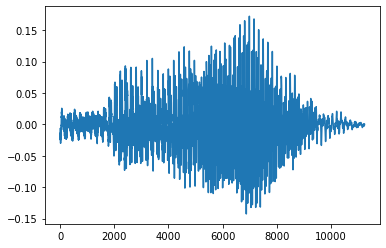

test2/digit-2.wav


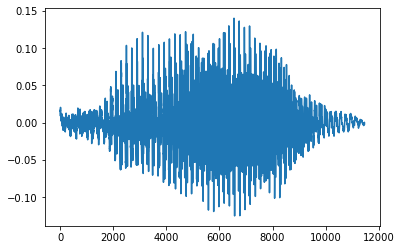

test2/digit-3.wav


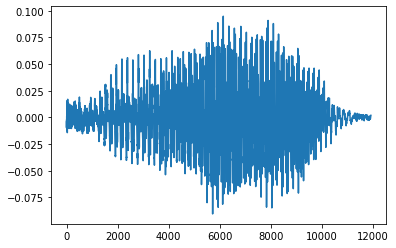

test2/digit-4.wav


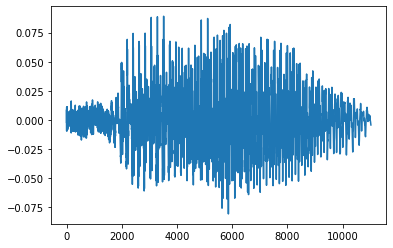

test2/digit-5.wav


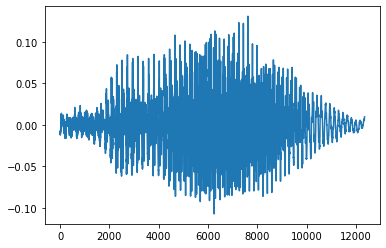

test2/digit-6.wav


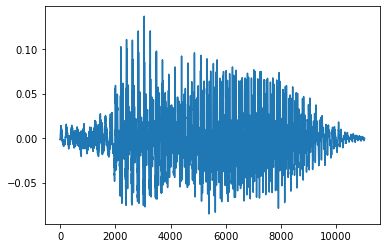

test2/digit-7.wav


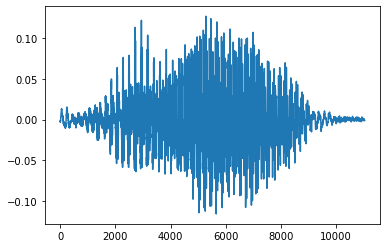

test2/digit-8.wav


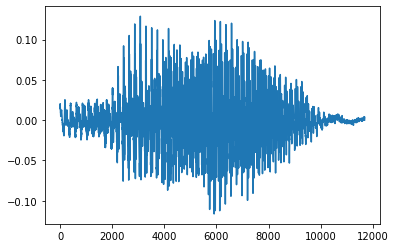

test2/digit-9.wav


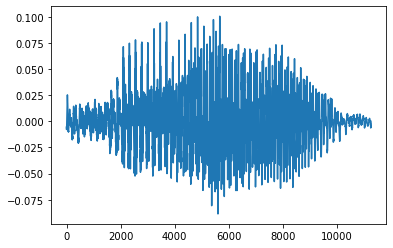

test2/digit-10.wav


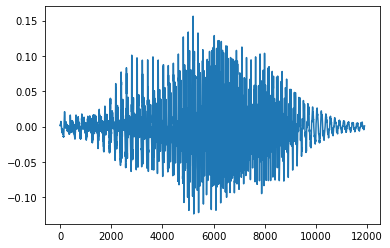

test2/digit-11.wav


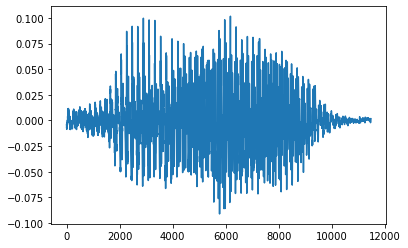

test2/digit-12.wav


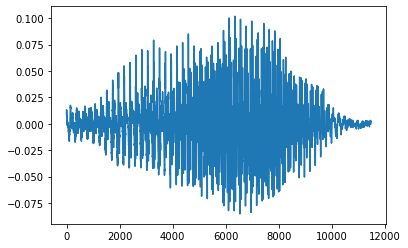

test2/digit-13.wav


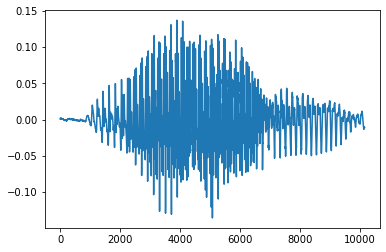

test2/digit-14.wav


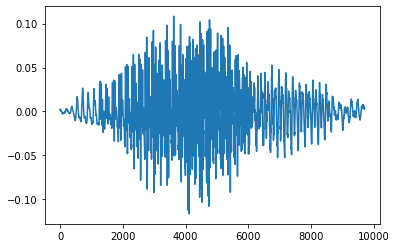

test2/digit-15.wav


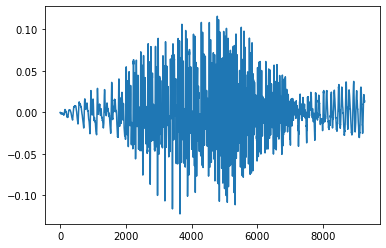

test2/digit-16.wav


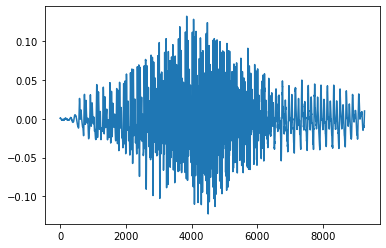

test2/digit-17.wav


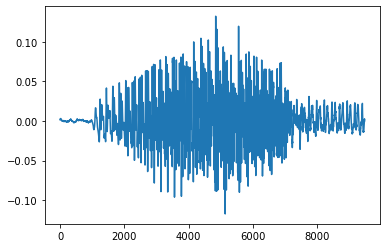

test2/digit-18.wav


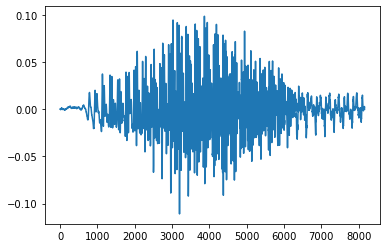

test2/digit-19.wav


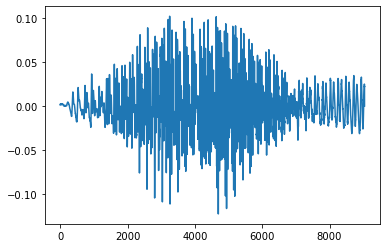

test2/digit-20.wav


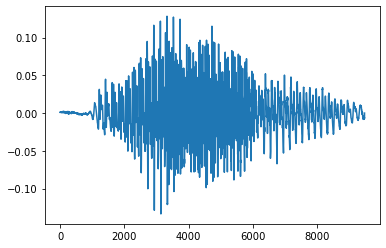

test2/digit-21.wav


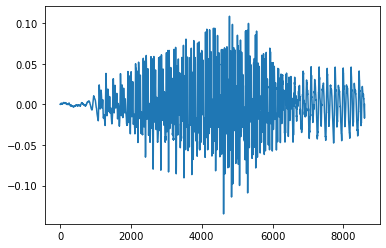

test2/digit-22.wav


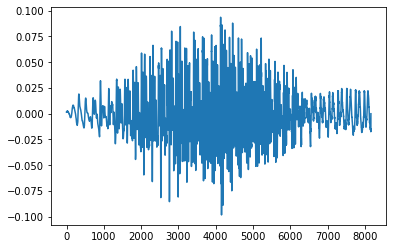

test2/digit-23.wav


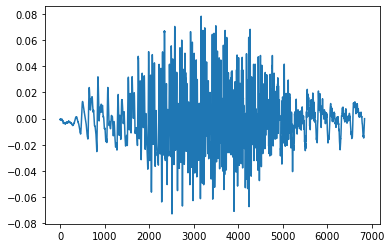

test2/digit-24.wav


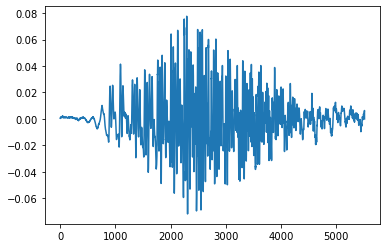

test2/digit-25.wav


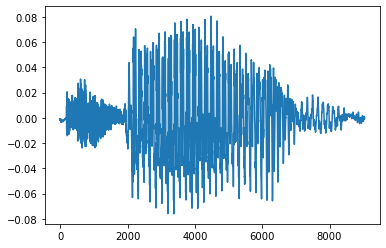

test2/digit-26.wav


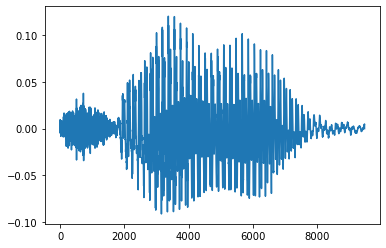

test2/digit-27.wav


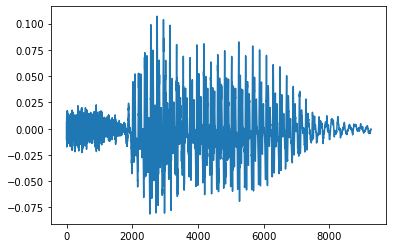

test2/digit-28.wav


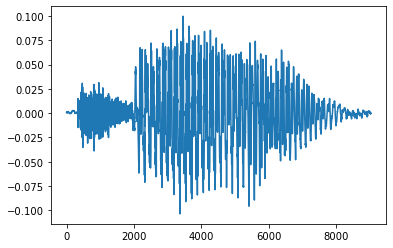

test2/digit-29.wav


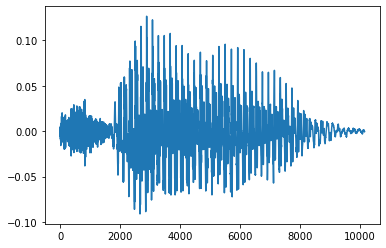

test2/digit-30.wav


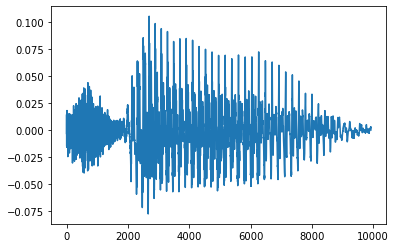

test2/digit-31.wav


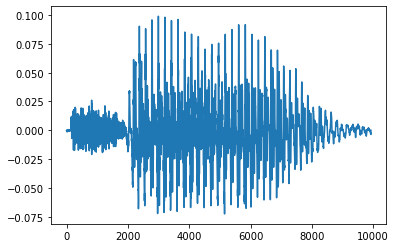

test2/digit-32.wav


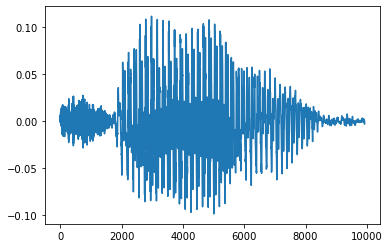

test2/digit-33.wav


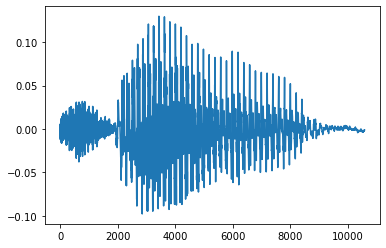

test2/digit-34.wav


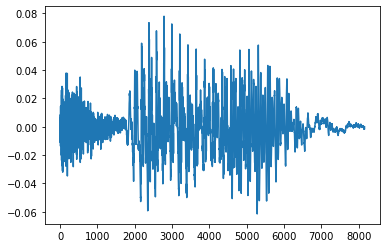

test2/digit-35.wav


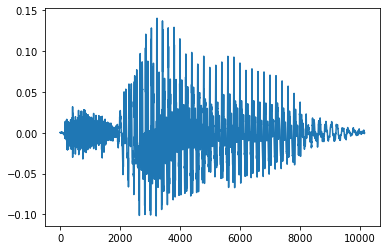

test2/digit-36.wav


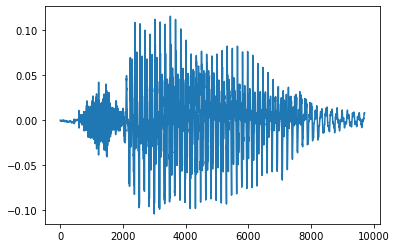

test2/digit-37.wav


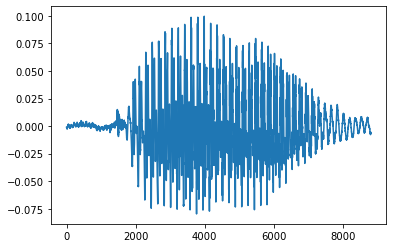

test2/digit-38.wav


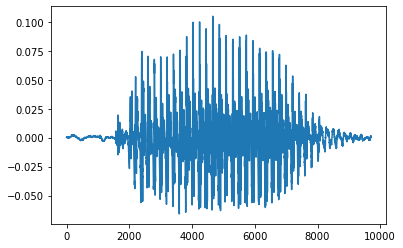

test2/digit-39.wav


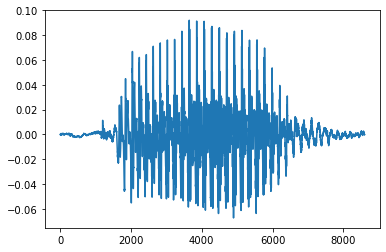

test2/digit-40.wav


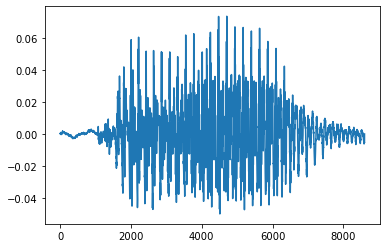

test2/digit-41.wav


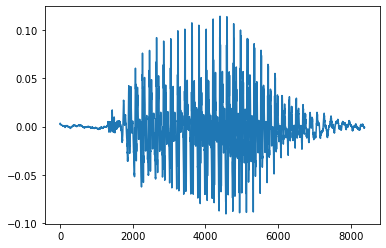

test2/digit-42.wav


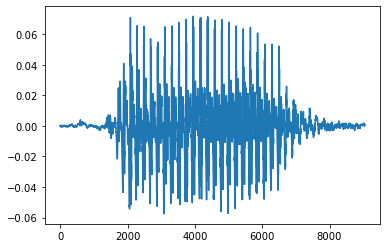

test2/digit-43.wav


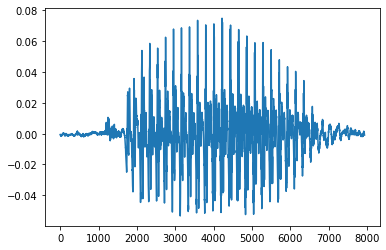

test2/digit-44.wav


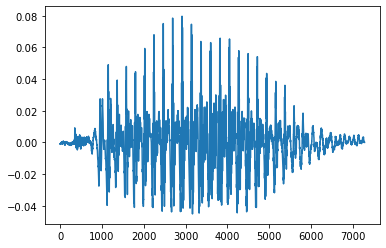

test2/digit-45.wav


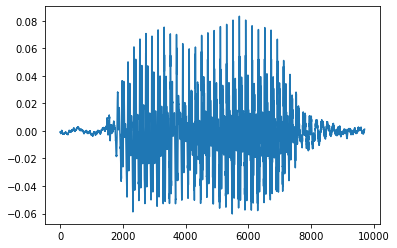

test2/digit-46.wav


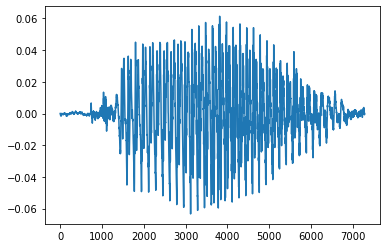

test2/digit-47.wav


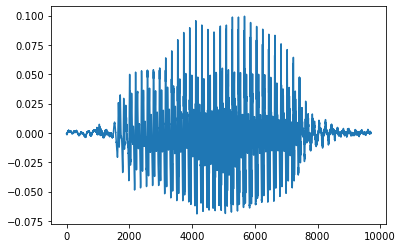

test2/digit-48.wav


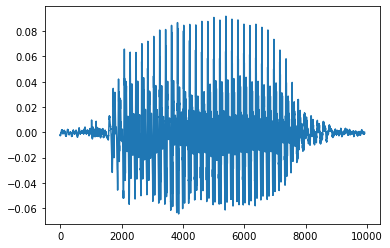

test2/digit-49.wav


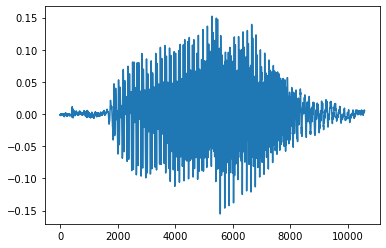

test2/digit-50.wav


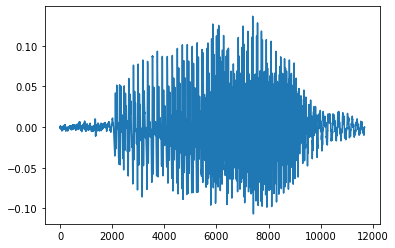

test2/digit-51.wav


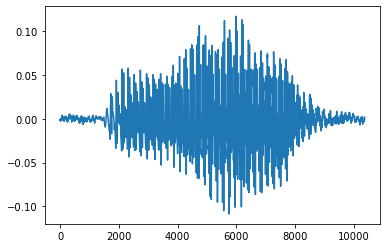

test2/digit-52.wav


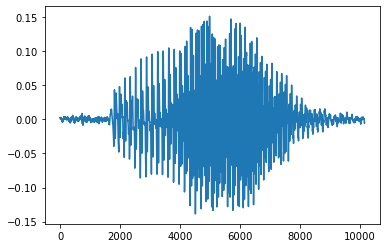

test2/digit-53.wav


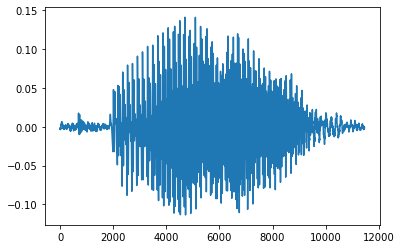

test2/digit-54.wav


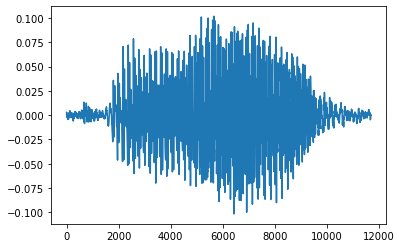

test2/digit-55.wav


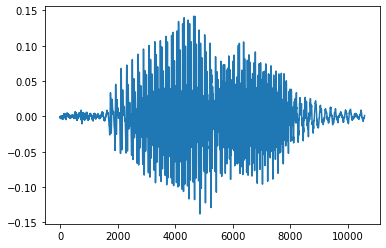

test2/digit-56.wav


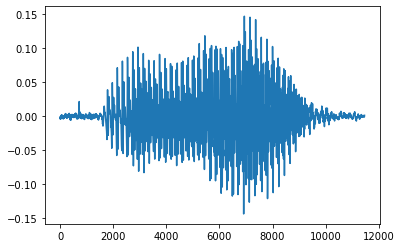

test2/digit-57.wav


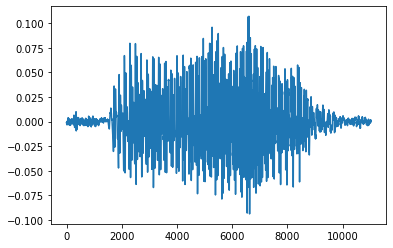

test2/digit-58.wav


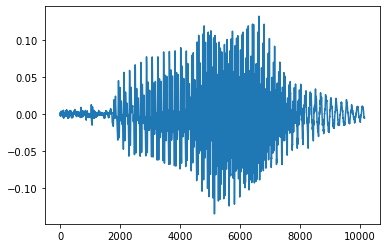

test2/digit-59.wav


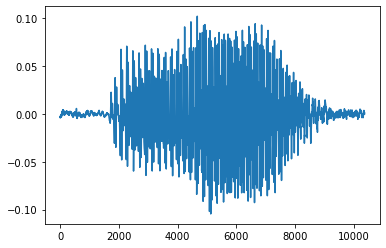

test2/digit-60.wav


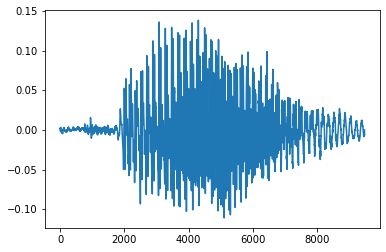

test2/digit-61.wav


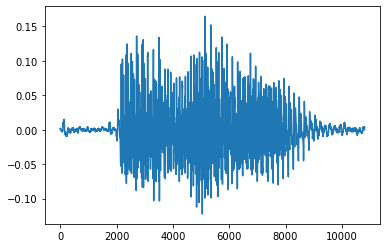

test2/digit-62.wav


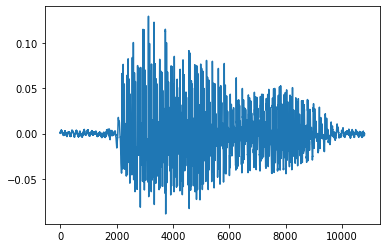

test2/digit-63.wav


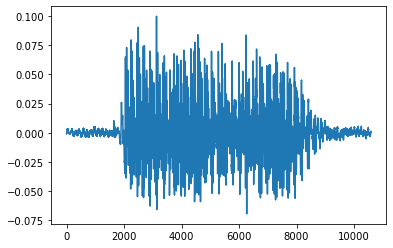

test2/digit-64.wav


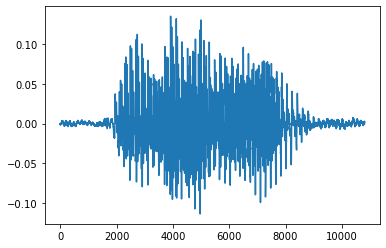

test2/digit-65.wav


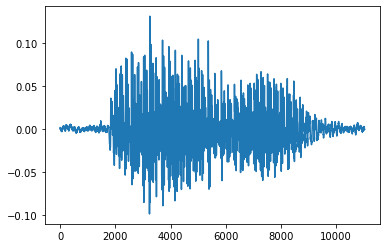

test2/digit-66.wav


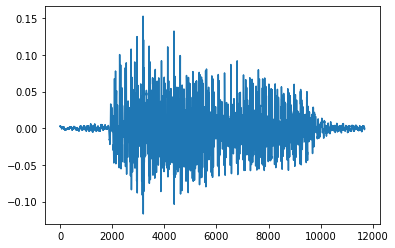

test2/digit-67.wav


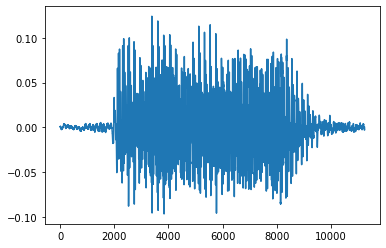

test2/digit-68.wav


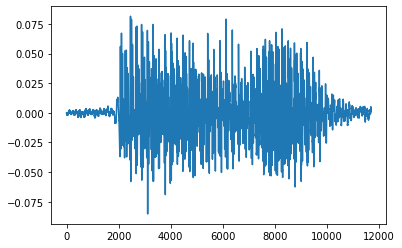

test2/digit-69.wav


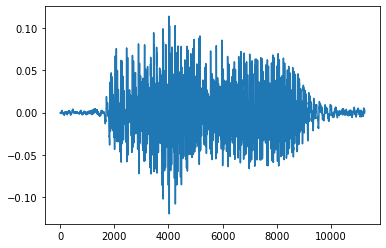

test2/digit-70.wav


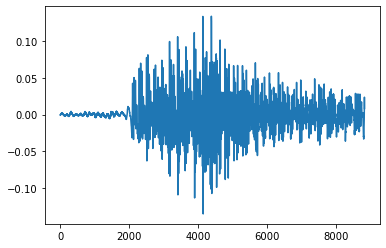

test2/digit-71.wav


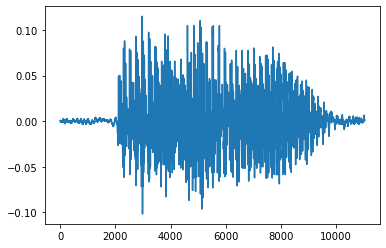

test2/digit-72.wav


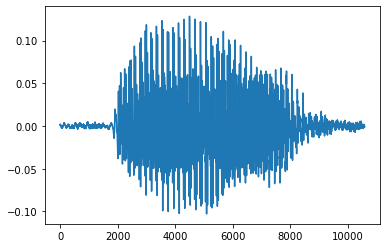

test2/digit-73.wav


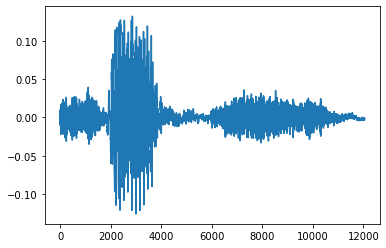

test2/digit-74.wav


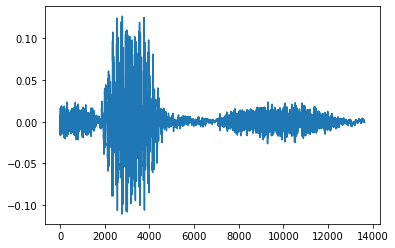

test2/digit-75.wav


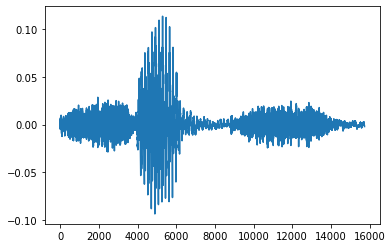

test2/digit-76.wav


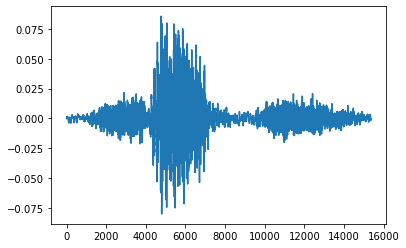

test2/digit-77.wav


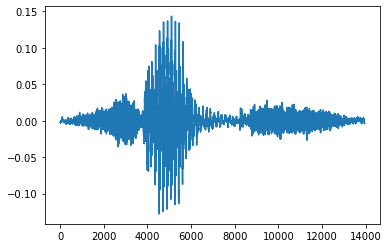

test2/digit-78.wav


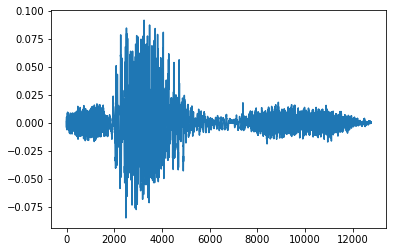

test2/digit-79.wav


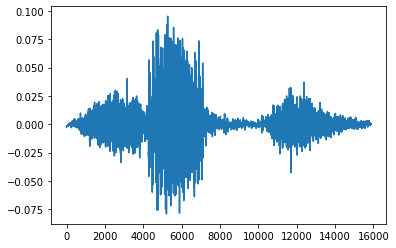

test2/digit-80.wav


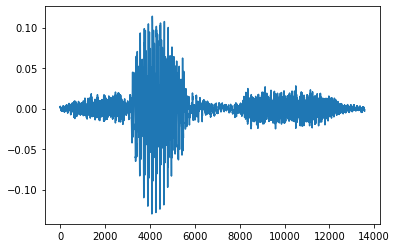

test2/digit-81.wav


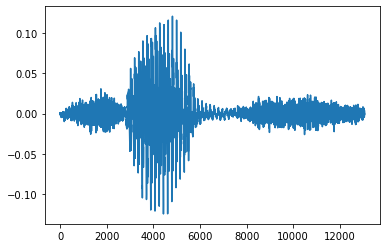

test2/digit-82.wav


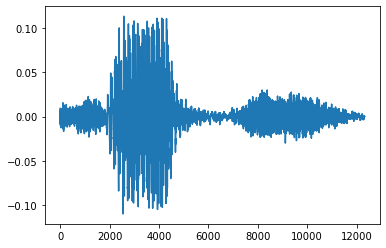

test2/digit-83.wav


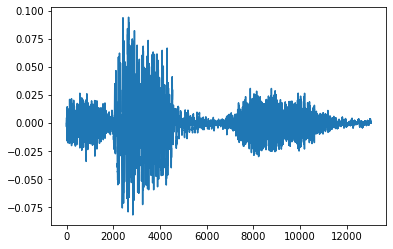

test2/digit-84.wav


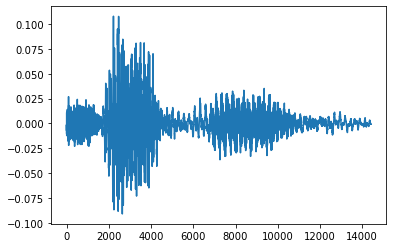

test2/digit-85.wav


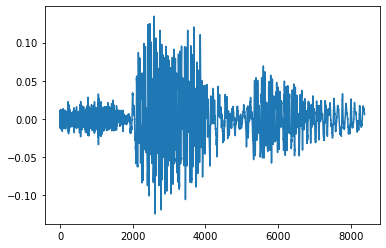

test2/digit-86.wav


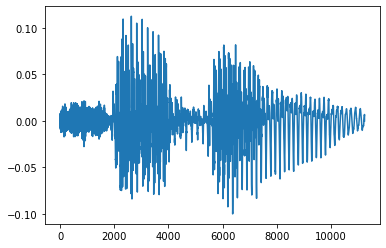

test2/digit-87.wav


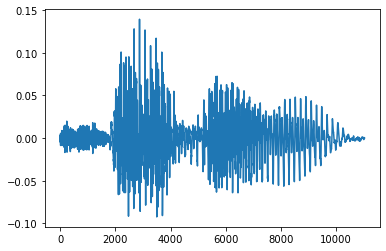

test2/digit-88.wav


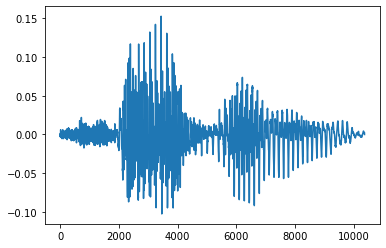

test2/digit-89.wav


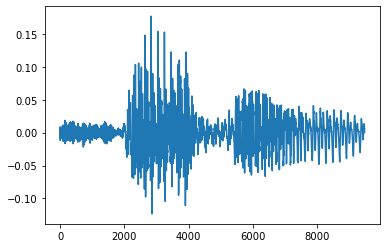

test2/digit-90.wav


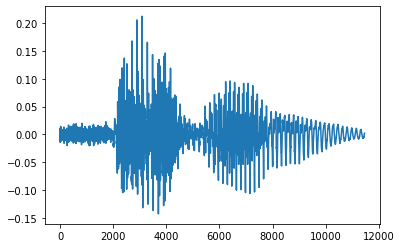

test2/digit-91.wav


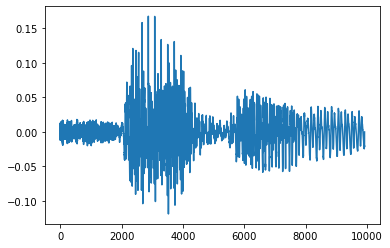

test2/digit-92.wav


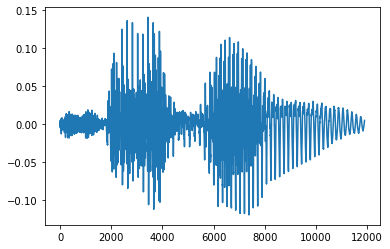

test2/digit-93.wav


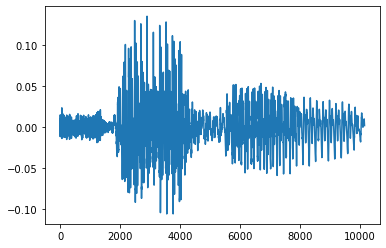

test2/digit-94.wav


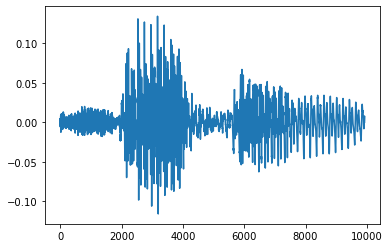

test2/digit-95.wav


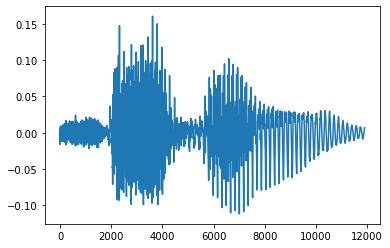

test2/digit-96.wav


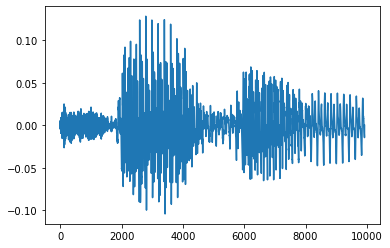

test2/digit-97.wav


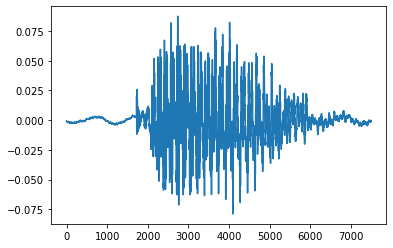

test2/digit-98.wav


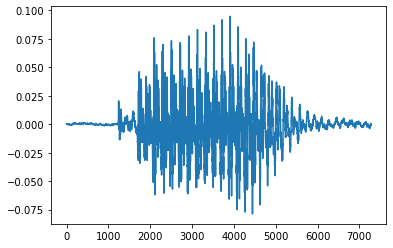

test2/digit-99.wav


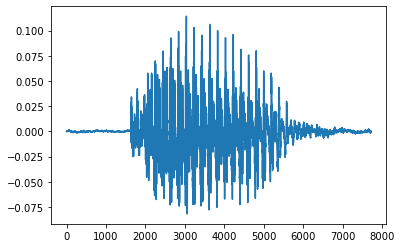

test2/digit-100.wav


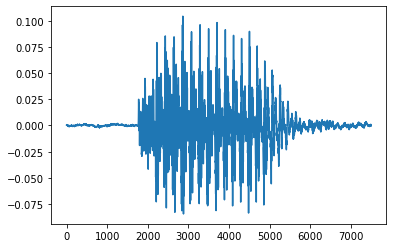

test2/digit-101.wav


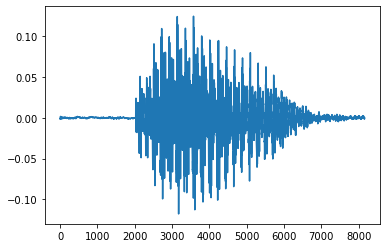

test2/digit-102.wav


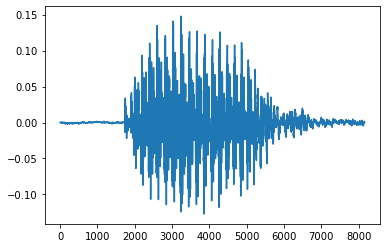

test2/digit-103.wav


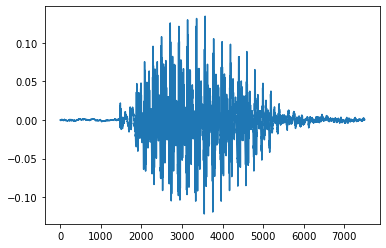

test2/digit-104.wav


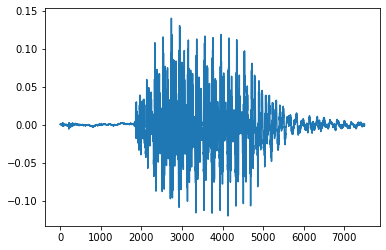

test2/digit-105.wav


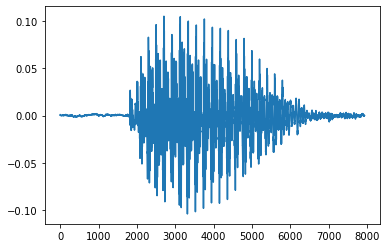

test2/digit-106.wav


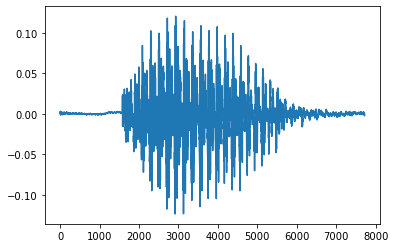

test2/digit-107.wav


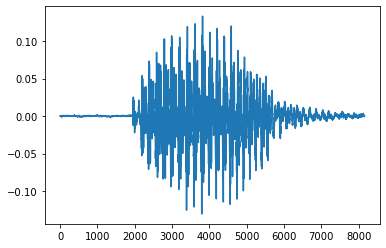

test2/digit-108.wav


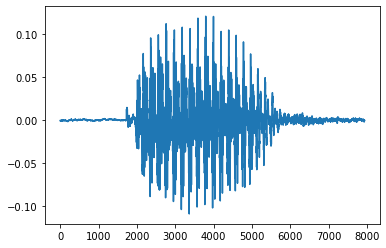

test2/digit-109.wav


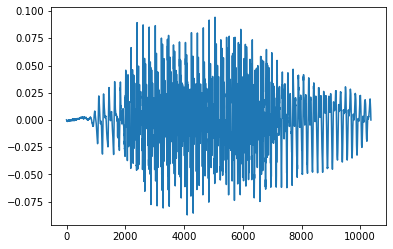

test2/digit-110.wav


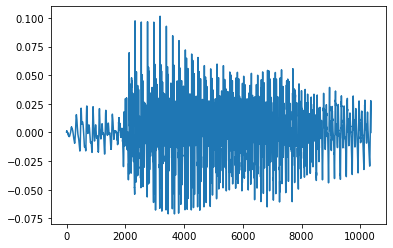

test2/digit-111.wav


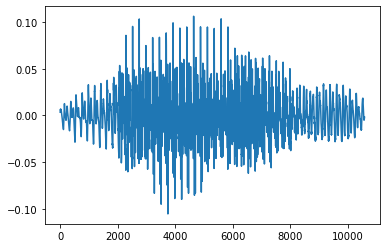

test2/digit-112.wav


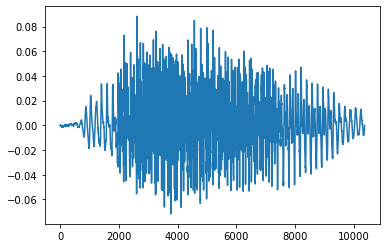

test2/digit-113.wav


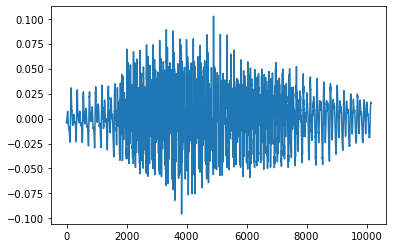

test2/digit-114.wav


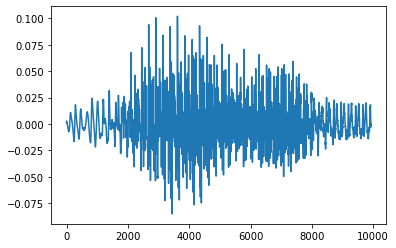

test2/digit-115.wav


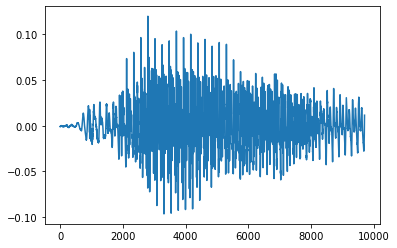

test2/digit-116.wav


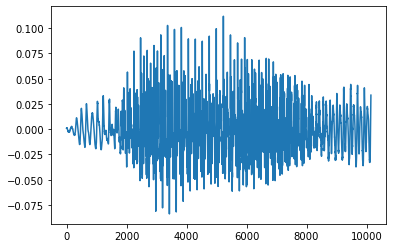

test2/digit-117.wav


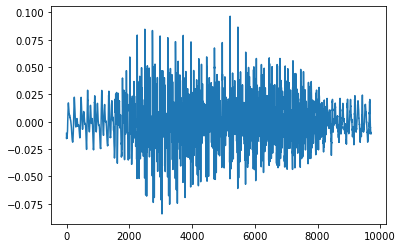

test2/digit-118.wav


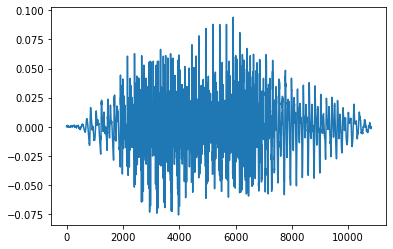

test2/digit-119.wav


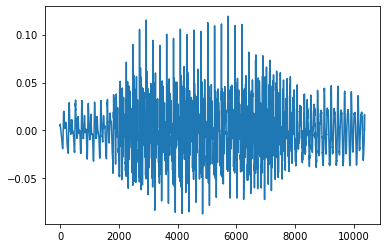

test2/digit-120.wav


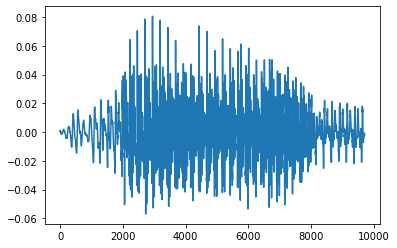

In [110]:
 mfccList,fileList, fileListNP, rate = loadMFCCfromDir()

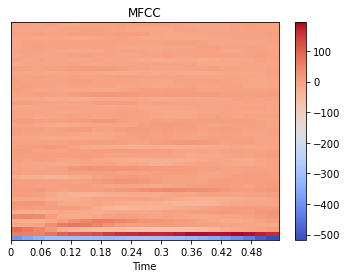

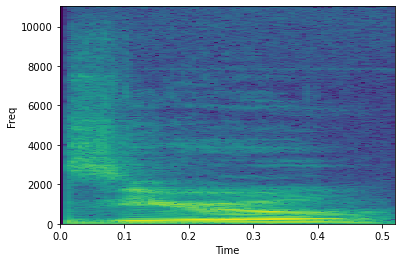

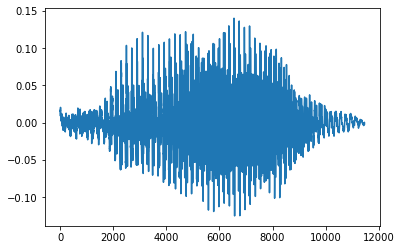

In [113]:
import matplotlib.pyplot as plt
from librosa import display

fig, ax = plt.subplots()
img = librosa.display.specshow(mfccList[1], x_axis='time', ax=ax)
sound(fileList[1],rate)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')
plt.show()
# template = 
# for digit in range(10):
plotSpectrogramTime(fileList[1],STFTResult, rate)
plt.plot(fileList[1])
plt.show()


In [26]:
template 
digits = []
digitMFCC = []


templates = {}
template_index = 2
for digit in X:
    # Choose one utterance as template
    templates[digit] = X[digit][template_index]
    
#get the non-template files
for file in fileList[1:]:
    digit = np.array_split(file, 10)
    digits.append(digit)
for mfcc in mfccList[1:]:
    digit = np.array_split(mfcc, 10)
    digitMFCC.append(digit)
digits = np.array(digits)

<ipython-input-26-6929eb9d03f0>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  digits = np.array(digits)


In [27]:
def getDistanceMatrix(a, b):
    out = np.zeros((a.shape[1], b.shape[1]))
    for i, frameA in enumerate(a.T):
        for j, frameB in enumerate(b.T):
            out[i,j] = dis.cosine(frameA,frameB)
    return out

def getCostMatrix(distMatrix):
    costMatrix = distMatrix.copy()
    costMatrix[0,-1] = distMatrix[0,-1]
    for j in range(-costMatrix.shape[0]):
        for i in range(costMatrix.shape[1]):
            if i == 0 and j == -1:
                continue
            curr = costMatrix[i,j]
            if i-1 >= 0:
                l = costMatrix[i-1, j] + curr
            else:
                l = np.nan
            if j+1 <= -1:
                d = costMatrix[i, j+1] + curr  
            else:
                d = np.nan
            if i-1 >= 0 and j+1 <= -1:
                ld = costMatrix[i-1, j+1] + curr  
            else:
                ld = np.nan
            costMatrix[i,j] = np.nanmin(l,d,ld)
    return costMatrix


def calculate_min_cost(distMatrix):
    # 0  - i-1, j-1
    # 1  - i, j-1
    # 2  - i-1, j
    cost = np.zeros(np.shape(distMatrix))
    path = np.zeros(np.shape(distMatrix))
    for i in range(np.size(distMatrix,0)):
        for j in range(np.size(distMatrix,1)):
            if i == 0 and j == 0:
                cost[i, j] = distMatrix[i, j]
                path[i, j] = -1
            elif j == 0:
                cost[i, j] = cost[i-1, j] + distMatrix[i, j]
                path[i, j] = 2
            elif i == 0:
                cost[i, j] = cost[i, j-1] + distMatrix[i, j]
                path[i, j] = 1
            else:
                costs = [cost[i-1, j-1], cost[i, j-1], cost[i-1, j]]
                cost[i, j] = np.min(costs) + distMatrix[i, j]
                path[i, j] = np.argmin(costs)
    minCost = cost[-1, -1]
    i = np.size(distMatrix,0) - 1
    j = np.size(distMatrix,1) - 1
    optimalPath = []
    while (path[i,j] != -1):
        optimalPath.append(a)
        prev = path[i, j]
        if prev == 0:
            i -= 1
            j -= 1
        elif prev == 1:
            j -= 1
        elif prev == 2:
            i -= 1
    return minCost, optimalPath[::-1]

def classify(template, testMFCC):
    out = []
    for currDigit, currMFCC in enumerate(template):
        distMatrix = getDistanceMatrix(currMFCC, testMFCC)
        costMatrix = getCostMatrix(distMatrix)
        optimalPathDistance = min(min(costMatrix[0]) , min(costMatrix.T[0]))
        print("optimal path distance for digit",currDigit, optimalPathDistance)
        out.append(optimalPathDistance)
    return np.argmin(np.array(out))

(119, 10)
10


optimal path distance for digit 0 0.4172062277793884
optimal path distance for digit 1 0.152005136013031
optimal path distance for digit 2 0.18172168731689453
optimal path distance for digit 3 0.11614197492599487
optimal path distance for digit 4 0.22747141122817993
optimal path distance for digit 5 0.14084267616271973
optimal path distance for digit 6 0.303499698638916
optimal path distance for digit 7 0.3802524209022522
optimal path distance for digit 8 0.44195806980133057
optimal path distance for digit 9 0.49870866537094116
the input digit is 3


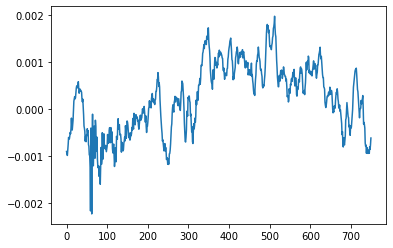

In [34]:
print(digits.shape)
plt.plot(digits[1][1])
print(len(template))
IPython.display.display( IPython.display.Audio(digits[1][1], rate=rate))
print("the input digit is",classify(template, digitMFCC[1][1]))

## Part 2. Making a voice-driven dialer

Suppose you just started working for a phone company and the first thing they ask you is to make a hands-free interface for their phones so that people can dial in their friends by voice. During setup, the users speak the name of a contact and then associate it with a number to call. Make a system for which you use the full name of 4-5 of your friends, so that when you speak their name the system recognizes it (and thus could subsequently call their number)

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()